<a href="https://colab.research.google.com/github/mahdiyahk/G-Research-Project/blob/main/momentum_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

shape: (5, 6)
┌────────────┬────────────┬──────────┬──────┬──────┬──────┐
│ Date       ┆ Close/Last ┆ Volume   ┆ Open ┆ High ┆ Low  │
│ ---        ┆ ---        ┆ ---      ┆ ---  ┆ ---  ┆ ---  │
│ date       ┆ f64        ┆ i64      ┆ f64  ┆ f64  ┆ f64  │
╞════════════╪════════════╪══════════╪══════╪══════╪══════╡
│ 2015-07-21 ┆ 1.8        ┆ 14982920 ┆ 1.82 ┆ 1.83 ┆ 1.78 │
│ 2015-07-22 ┆ 1.79       ┆ 15993970 ┆ 1.8  ┆ 1.81 ┆ 1.76 │
│ 2015-07-23 ┆ 1.76       ┆ 10612790 ┆ 1.8  ┆ 1.81 ┆ 1.75 │
│ 2015-07-24 ┆ 1.67       ┆ 16042430 ┆ 1.76 ┆ 1.77 ┆ 1.65 │
│ 2015-07-27 ┆ 1.62       ┆ 11907530 ┆ 1.67 ┆ 1.7  ┆ 1.61 │
└────────────┴────────────┴──────────┴──────┴──────┴──────┘


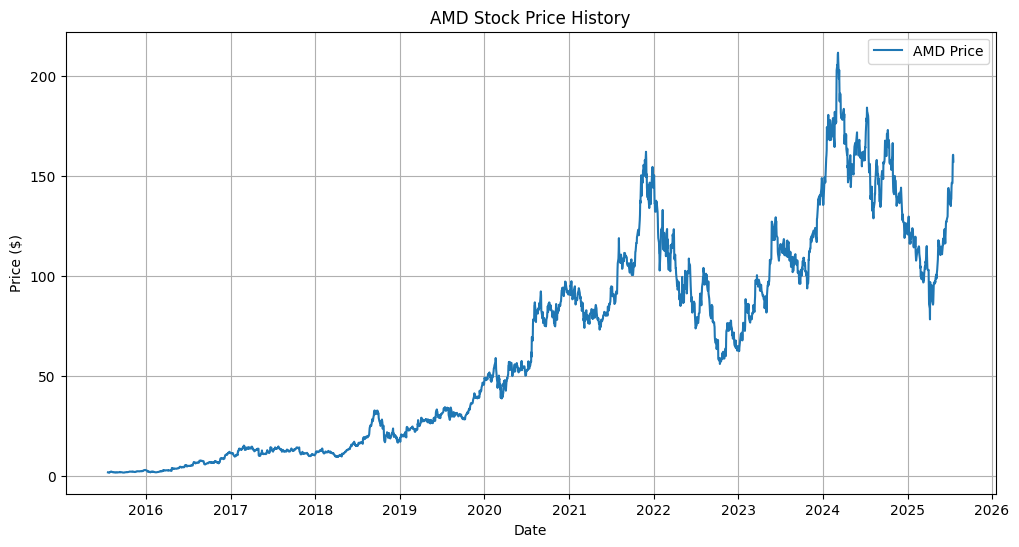

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl



#loading the csv file
df = pl.read_csv('AMD.csv')
# for price in df['Close/Last']:
#   price = price[1:]
money_cols = ['Close/Last', 'Open', 'High', 'Low']
for col in money_cols:
    df = df.with_columns(
        pl.col(col).str.replace("[$]", "").cast(pl.Float64)# remove the dollar sign and convert into float values
    )
#convert here to datetime format for better sorting
df = df.with_columns(
  pl.col('Date').str.strptime(pl.Date, "%m/%d/%Y")
)

df = df.sort("Date")

print(df.head())


#use matplotlib to plot the data because more familiar with it
plt.figure(figsize=(12,6))
plt.plot(df["Date"].to_list(), df["Close/Last"].to_list(), label="AMD Price") #here the close is the closing price which is being plotted
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.title("AMD Stock Price History")
plt.grid(True)
plt.legend()
plt.show()







In [ ]:

# previous price is the row above the current close
df = df.with_columns(
    pl.col('Close/Last').shift(1).alias("Previous_Price")
)


# adding a column here where if the price is greater than the previous price then there is a momentum signal as a boolean
df = df.with_columns([(pl.col('Close/Last') > pl.col('Previous_Price')).alias("Momentum_Signal")])
# Adding a new column with daily returns measured as a percentage
df = df.with_columns([
    (pl.col("Close/Last").pct_change(1) * 100.00).alias("Daily Return") ])
#adding a column for actual directions so the direction on the day depending if the daily return was positive or negative
df = df.with_columns([
    (pl.col("Daily Return") > 0).alias("Actual_Direction")
])

# Adding a new column with daily returns

df = df.with_columns([
    (pl.col("Momentum_Signal").shift(1) == pl.col("Actual_Direction")).alias("Correct_Prediction")
])


# Displaying the DataFrame with the new column
print(df.head())


shape: (5, 11)
┌────────────┬────────────┬──────────┬──────┬───┬────────────┬────────────┬────────────┬───────────┐
│ Date       ┆ Close/Last ┆ Volume   ┆ Open ┆ … ┆ Momentum_S ┆ Daily      ┆ Actual_Dir ┆ Correct_P │
│ ---        ┆ ---        ┆ ---      ┆ ---  ┆   ┆ ignal      ┆ Return     ┆ ection     ┆ rediction │
│ date       ┆ f64        ┆ i64      ┆ f64  ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---       │
│            ┆            ┆          ┆      ┆   ┆ bool       ┆ f64        ┆ bool       ┆ bool      │
╞════════════╪════════════╪══════════╪══════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 2015-07-21 ┆ 1.8        ┆ 14982920 ┆ 1.82 ┆ … ┆ null       ┆ null       ┆ null       ┆ null      │
│ 2015-07-22 ┆ 1.79       ┆ 15993970 ┆ 1.8  ┆ … ┆ false      ┆ -0.555556  ┆ false      ┆ null      │
│ 2015-07-23 ┆ 1.76       ┆ 10612790 ┆ 1.8  ┆ … ┆ false      ┆ -1.675978  ┆ false      ┆ true      │
│ 2015-07-24 ┆ 1.67       ┆ 16042430 ┆ 1.76 ┆ … ┆ false      ┆ -5.113636  ┆ 

MSE (no fee): 1.5993564288889996
Correlation (no fee): 0.9060168662285144


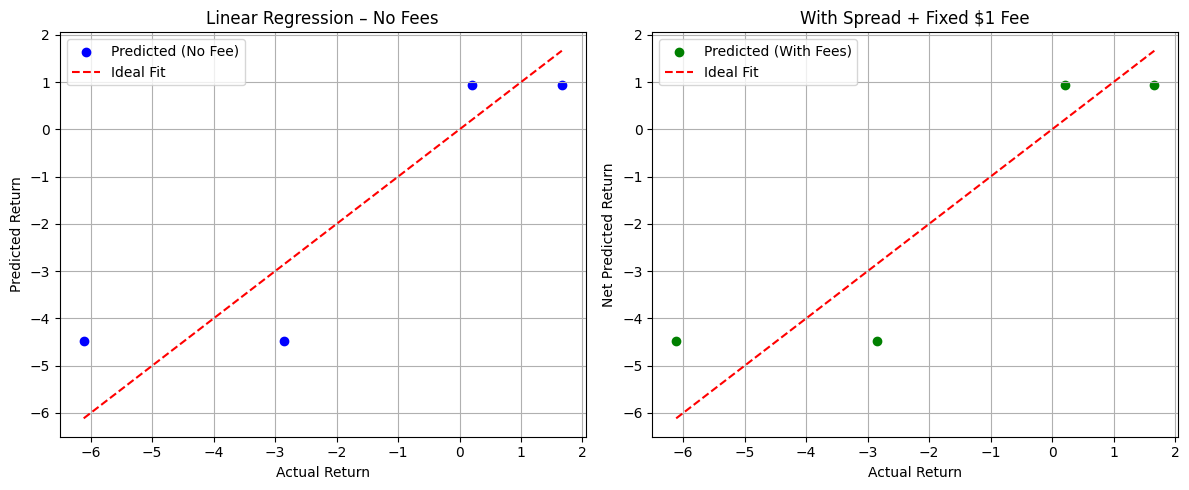

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Signals
Momentum_signal = [None, True, False, True, False]

# Convertung into numeric signals so none = np.nan, True = 1, False = 0
momentum = np.array([1 if s is True else 0 if s is False else np.nan for s in Momentum_signal])

# Daily returns
daily_return = np.array([np.nan, 1.664331, -6.113032, 0.203505, -2.847938])

# Remove NaN values
mask = ~np.isnan(momentum) & ~np.isnan(daily_return)
X = momentum[mask].reshape(-1, 1)
y = daily_return[mask]

# Linear Regression graph
model = LinearRegression()
model.fit(X, y)

# Predicted
predicted_returns = model.predict(X)

# MSE & Correlation
mse = mean_squared_error(y, predicted_returns)
corr, _ = pearsonr(y, predicted_returns)

print("MSE (no fee):", mse)
print("Correlation (no fee):", corr)


# Fees
spread_fee = 0.00001
capital = 100000
fixed_fee = 1 / capital
total_fee = spread_fee + fixed_fee

# Apply fees only on trades
net_predicted_returns = np.where(X.flatten() == 1, predicted_returns - total_fee, predicted_returns)

# Plotting graphs
min_y, max_y = min(y), max(y)

plt.figure(figsize=(12, 5))

# Left, original
plt.subplot(1, 2, 1)
plt.scatter(y, predicted_returns, color='blue', label='Predicted (No Fee)')
plt.plot([min_y, max_y], [min_y, max_y], 'r--', label='Ideal Fit')
plt.xlabel("Actual Return")
plt.ylabel("Predicted Return")
plt.title("Linear Regression – No Fees")
plt.grid(True)
plt.legend()

# Right, with fees
plt.subplot(1, 2, 2)
plt.scatter(y, net_predicted_returns, color='green', label='Predicted (With Fees)')
plt.plot([min_y, max_y], [min_y, max_y], 'r--', label='Ideal Fit')
plt.xlabel("Actual Return")
plt.ylabel("Net Predicted Return")
plt.title("With Spread + Fixed $1 Fee")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go

# Sample data
x = [514.48, 505.68, 505.18, 503.02, 501.52]
y = [514.48, 514.48, 505.68, 505.68,503.02]

# Create a line plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines'))
fig.update_layout(title='Prediction vs reality', xaxis_title='Time', yaxis_title='Price')
fig.show()

In [ ]:
import pandas as pd
import numpy as np

def moving_average_crossover_strategy(prices, nf, ns):

    # Convert prices to a Pandas Series if it's a list
    if isinstance(prices, list):
        prices = pd.Series(prices)

    # Calculate the fast moving average
    # MA_fast(t) = avg(P(t), ..., P(t-nf+1))
    ma_fast = prices.rolling(window=nf, min_periods=1).mean()

    # Calculate the slow moving average
    # MA_slow(t) = avg(P(t), ..., P(t-ns+1))
    ma_slow = prices.rolling(window=ns, min_periods=1).mean()

    # Generate the buy signal
    # signal(t+1) = 1 if MA_fast(t) > MA_slow(t), else 0
    signal = pd.Series(0, index=prices.index)
    signal[ma_fast > ma_slow] = 1

    return signal




Final Account Value: 2947719.38


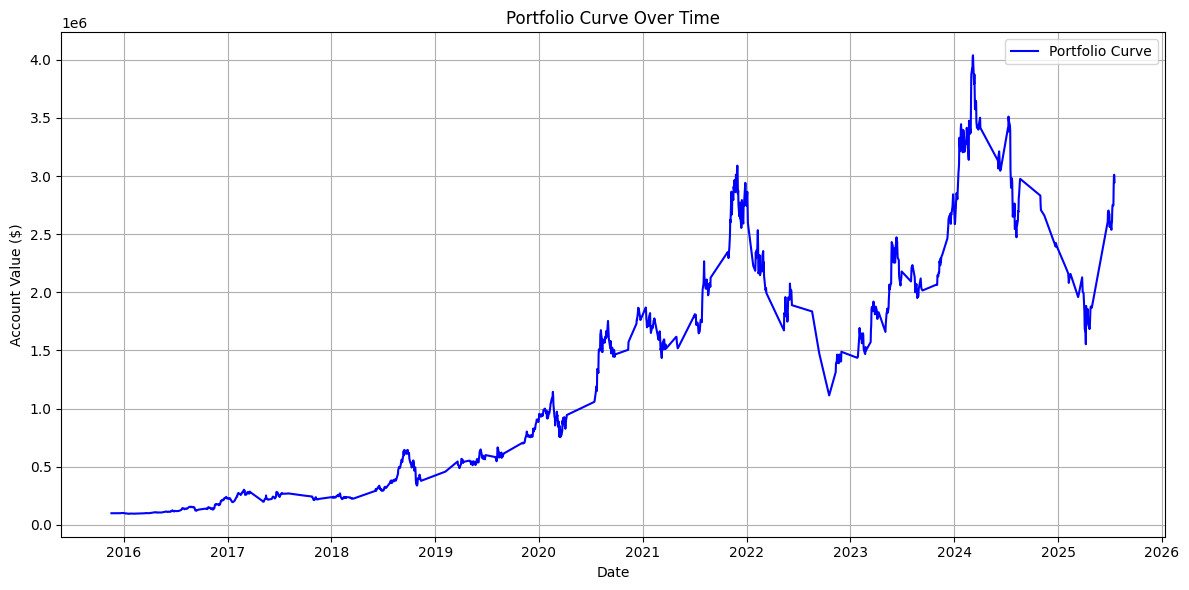


Sharpe Ratio: 1.3726


Date,Close/Last,Volume,Open,High,Low,Previous_Price,Momentum_Signal,Daily Return,Actual_Direction,Correct_Prediction,MA_Crossover_Signal,Close,n_day_return,N_Return_Signal
datetime[ms],f64,i64,f64,f64,f64,f64,bool,f64,bool,bool,f64,f64,f64,f64
2015-07-21 00:00:00,1.8,14982920,1.82,1.83,1.78,null,null,null,null,null,null,1.8,null,null
2015-07-22 00:00:00,1.79,15993970,1.8,1.81,1.76,1.8,false,-0.555556,false,null,0.0,1.79,null,0.0
2015-07-23 00:00:00,1.76,10612790,1.8,1.81,1.75,1.79,false,-1.675978,false,true,0.0,1.76,null,0.0
2015-07-24 00:00:00,1.67,16042430,1.76,1.77,1.65,1.76,false,-5.113636,false,true,0.0,1.67,null,0.0
2015-07-27 00:00:00,1.62,11907530,1.67,1.7,1.61,1.67,false,-2.994012,false,true,0.0,1.62,null,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-07-14 00:00:00,146.24,44718550,145.09,147.58,141.9,146.42,false,-0.122934,false,false,1.0,146.24,0.084866,1.0
2025-07-15 00:00:00,155.61,93370080,153.75,158.68,153.56,146.24,true,6.407276,true,false,1.0,155.61,0.129081,1.0
2025-07-16 00:00:00,160.08,59492760,155.31,160.36,152.85,155.61,true,2.872566,true,true,1.0,160.08,0.156564,1.0


In [ ]:
import pandas as pd
import polars as pl

def simulate_trades(df, intraday = False):
    # Add Buy and Sell Signals as Boolean columns

    pdf = df.to_pandas() # Convert the Polars DataFrame with 'Date' column to pandas
    capital = 100000 #starting amount
    shares_held = 0
    buy_amount = 100 # we are currently only buying and selling 100 shares at a time
    sell_amount = 100
    portfolio_value = 0
    trades = []
    equity_curve = []
    momentum_signals = []



    # Convert Momentum_Signal to float 1.0 or 0.0 before iterating as they are currently booleans
    pdf['Momentum_Signal'] = pdf['Momentum_Signal'].astype(float)

    #create an atr column for the data to be used for the volatility signal
    pdf = calculate_atr(pdf, atr_period=14, ma_period=50)



    #this is used to get our volatility signal which is updated to the new pandas dataframe
    for index, row in pdf.iterrows(): # Iterate through rows to access date for each signal
      signal = row['Momentum_Signal']
      trade_date = pd.to_datetime(row['Date'])
      share_price = float(row['Close/Last'])
      vol_ok = row['Volatility_Signal']
      ma_signal = row['MA_Crossover_Signal']
      return_signal = row.get('N_Return_Signal', 0)
      momentum_signals.append((trade_date, signal))
      #if volatility of stock not good we won't trade for that day
      if not vol_ok:
        continue

      #Buy go long sell position
      if signal == 1.0 and ma_signal == 1 and return_signal == 1.0: # Our strategy uses the momentum signal, ma signal and return signal from n days and the volatility signal
      #Buy go long sell position


    # RISK MANAGEMENT IMPLEMENTATION
        atr = row['ATR']
        stop_loss_pct = 2  # assume a 2 ATR stop-loss multiplier
        risk_per_trade = 0.01  # 1% of capital
        risk_amount = capital * risk_per_trade # calculate the risk per stocl

        # Position sizing based on ATR
        stop_loss_dollars = atr * stop_loss_pct
        if stop_loss_dollars == 0:
            continue  # avoid division by zero
        dynamic_shares = int(risk_amount / stop_loss_dollars)

        # Apply cap to avoid oversized trades (optional)
        max_shares = 500
        dynamic_shares = min(dynamic_shares, max_shares)

        # Final cost
        cost = share_price * dynamic_shares
        total_cost = cost + add_fees(cost)


        #buying the shares
        if capital >= total_cost and dynamic_shares > 0:
            shares_held += dynamic_shares
            capital -= total_cost
            trades.append(f"{trade_date.date()}: BUY {dynamic_shares} @ {share_price:.2f}, capital: {capital:.2f}")



        cost = share_price * buy_amount
        total_cost = cost + add_fees(cost)
        if capital >= total_cost:
          shares_held += buy_amount
          capital -= total_cost
          trades.append(f"{trade_date.date()}: BUY {buy_amount} @ {share_price:.2f}, capital: {capital:.2f}")


      # close the long position
      elif signal == 0.0 and ma_signal == 0 and return_signal == -1.0: # same strategy modified for selling stocks


        if shares_held >= sell_amount:
          revenue = share_price * sell_amount
          net_revenue = revenue - add_fees(revenue)
          shares_held -= sell_amount
          capital += net_revenue
          trades.append(f"{trade_date.date()}: SELL {sell_amount} @ {share_price:.2f}, capital: {capital:.2f}")


      #sell all shares at end of the day or implement holding positions depeding on value of intraday
      if intraday and shares_held > 0:
        revenue = share_price * shares_held
        net_revenue = revenue - add_fees(revenue)
        capital += net_revenue
        trades.append(f"{trade_date.date()}: EOD SELL ALL @ {share_price:.2f}")
        shares_held = 0


      # This is the portfolio value which is the capital add the total value of shares
      total_value = capital + (shares_held * share_price)
      equity_curve.append((trade_date, total_value))
    print(f"\nFinal Account Value: {capital + (shares_held * share_price):.2f}")
    plot_portfolio_curve(equity_curve)

    #calculate the sharpe ratio
    sharpe = sharpe_ratio(equity_curve)

    print(f"\nSharpe Ratio: {sharpe:.4f}")
    return df





def add_fees(amount):
  fixed_fee = 1.00 # Changed from string to float

  # 0.001% percent of all fees
  spread_fee_rate = 0.00001

  return fixed_fee + (amount * spread_fee_rate)




def plot_portfolio_curve(equity_curve):
    dates, values = zip(*equity_curve)# equity curve is a nested list storing lists of dates and equity at that time
    plt.figure(figsize=(12, 6))
    plt.plot(dates, values, label='Portfolio Curve', color='blue')
    plt.xlabel('Date')
    plt.ylabel('Account Value ($)')
    plt.title('Portfolio Curve Over Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



def calculate_atr(df, atr_period = 14, ma_period = 50):
  # Convert columns to numeric
  df['High'] = pd.to_numeric(df['High'])
  df['Low'] = pd.to_numeric(df['Low'])
  df['Close/Last'] = pd.to_numeric(df['Close/Last'])

  high = df['High']
  low = df['Low']
  close_prev = df['Close/Last'].shift(1)
  tr = pd.concat([high - low, abs(high - close_prev), abs(low - close_prev)], axis=1).max(axis=1)
  atr = tr.rolling(atr_period).mean()
  atr_ma = atr.rolling(ma_period).mean()

  df['ATR'] = atr
  df['ATR_MA'] = atr_ma
  df['Volatility_Signal'] = atr > atr_ma

  return df

df = add_ma_signal_to_df(df)
df = add_n_day_return_signal(df, n=5, threshold=0.02)
simulate_trades(df)

In [ ]:
import pandas as pd
import numpy as np

def n_day_return_strategy(data, n, threshold):



    #  'signal' is 1 for a buy signal, -1 for a sell signal, and 0 otherwise.

    # Calculate n-day return
    # return(t) = (P(t) - P(t-n)) / P(t-n)
    data['n_day_return'] = (data['Close'] - data['Close'].shift(n)) / data['Close'].shift(n) #

    # Generate trading signals
    # signal(t+1) = 1 if return(t) > θ, -1 if return(t) < -θ, 0 otherwise
    data['signal'] = np.where(data['n_day_return'] > threshold, 1, np.where(data['n_day_return'] < -threshold, -1, 0)) #

    # Shift the signal by one day as the signal is for the next trading day
    data['signal'] = data['signal'].shift(1) #

    return data



# Set parameters
n_days = 5  # Calculate 5-day return
threshold_value = 0.02 # set threshold for generating a signal as 2%

# Apply the strategy
df_with_signals = n_day_return_strategy(df.copy(), n_days, threshold_value)

# Display the results
print(df_with_signals.tail(10))

                Close  n_day_return  signal
2024-03-31  93.948647     -0.023343     0.0
2024-04-01  93.298270     -0.015389    -1.0
2024-04-02  93.581010     -0.007681     0.0
2024-04-03  94.424248      0.011006     0.0
2024-04-04  94.663132      0.004052     0.0
2024-04-05  94.232585      0.003022     0.0
2024-04-06  95.100916      0.019321     0.0
2024-04-07  94.641898      0.011337     0.0
2024-04-08  94.549569      0.001327     0.0
2024-04-09  93.167451     -0.015800     0.0


In [ ]:
import pandas as pd
import numpy as np
#modfied to work with the simulate trade
def moving_average_crossover_strategy(prices, nf, ns):


    if isinstance(prices, list):
        prices = pd.Series(prices)

    # Calculate the fast moving average
    # MA_fast(t) = avg(P(t), ..., P(t-nf+1))
    ma_fast = prices.rolling(window=nf, min_periods=1).mean()

    # Calculate the slow moving average
    # MA_slow(t) = avg(P(t), ..., P(t-ns+1))
    ma_slow = prices.rolling(window=ns, min_periods=1).mean()

    # Generate the buy signal
    # signal(t+1) = 1 if MA_fast(t) > MA_slow(t), else 0
    signal = pd.Series(0, index=prices.index)
    signal[ma_fast > ma_slow] = 1

    return signal



In [ ]:
def add_ma_signal_to_df(df: pl.DataFrame, nf=5, ns=20) -> pl.DataFrame:
    # Convert to Pandas
    # add signal in pandas from the ma crossover function, and convert a copy back to polars form
    pdf = df.to_pandas()
    pdf["MA_Crossover_Signal"] = moving_average_crossover_strategy(pdf["Close/Last"], nf, ns).shift(1)

    # Convert back to Polars
    return pl.from_pandas(pdf)


In [ ]:
def sharpe_ratio(equity_curve, risk_free_rate=0.0):

    equity_df = pd.DataFrame(equity_curve, columns=['Date', 'Value'])
    equity_df['Daily_Return'] = equity_df['Value'].pct_change()

    # Calculate average daily return and standard deviation of daily returns
    avg_daily_return = equity_df['Daily_Return'].mean()
    std_daily_return = equity_df['Daily_Return'].std()

    # Annualise the risk-free rate
    annualised_risk_free_rate = risk_free_rate / 252 # only 252 trading days per year

    # Calculate Sharpe Ratio
    if std_daily_return == 0:
        return 0 # Avoid division by zero
    else:
        sharpe = (avg_daily_return - annualised_risk_free_rate) / std_daily_return
        return sharpe * np.sqrt(252) #  the Sharpe Ratio


'\ndf = add_ma_signal_to_df(df)\n\n\ndf = add_n_day_return_signal(df, n=5, threshold=0.02)\n\n\n\nsimulated_df = simulate_trades(df)\n'

In [ ]:

def add_n_day_return_signal(df, n, threshold):

    pdf = df.to_pandas()
    pdf['Close'] = pd.to_numeric(pdf['Close/Last'])

    pdf['n_day_return'] = (pdf['Close'] - pdf['Close'].shift(n)) / pdf['Close'].shift(n)


    pdf['N_Return_Signal'] = np.where(
        pdf['n_day_return'] > threshold, 1,
        np.where(pdf['n_day_return'] < -threshold, -1, 0)
    )


    pdf['N_Return_Signal'] = pdf['N_Return_Signal'].shift(1)

    return pl.from_pandas(pdf)


In [ ]:
# Showing no look ahead
import pandas as pd

# Adding data
data_dict = {
    "Date": ["2015-07-21", "2015-07-22", "2015-07-23", "2015-07-24", "2015-07-27", "2015-07-28", "2015-07-29", "2015-07-30", "2015-07-31"],
    "Close/Last": [47.28, 45.54, 46.11, 45.94, 45.35, 45.34, 46.29, 46.88, 46.70],
    "Volume": [42211210, 59039160, 33708200, 32304070, 39472930, 34309080, 40924210, 39755700, 31192430],
    "Open": [46.78, 45.44, 45.27, 45.91, 45.94, 45.58, 45.40, 46.26, 47.29],
    "High": [47.33, 46.93, 46.23, 46.32, 46.01, 45.64, 46.78, 47.40, 47.37],
    "Low": [46.48, 45.203, 45.1, 45.8, 45.25, 44.79, 45.26, 45.93, 46.50]
}

data = pd.DataFrame(data_dict)
data['Date'] = pd.to_datetime(data['Date'])

# 5 day movinh average shifted by 1
data['ma_5'] = data['Close/Last'].rolling(window=5).mean().shift(1)

# Create a signal column for buying & selling
data['signal'] = 0
for i in range(6, len(data)):
    if data.loc[i-1, 'Close/Last'] < data.loc[i-1, 'ma_5'] and data.loc[i, 'Close/Last'] > data.loc[i, 'ma_5']:
        data.loc[i, 'signal'] = 1

# Trade entry price = next days open
data['entry_price'] = data['Open'].shift(-1)

# Remove NaN entry
data = data.dropna(subset=['entry_price'])

# Creting table
print(data[['Date', 'Close/Last', 'ma_5', 'signal', 'entry_price']])


        Date  Close/Last    ma_5  signal  entry_price
0 2015-07-21       47.28     NaN       0        45.44
1 2015-07-22       45.54     NaN       0        45.27
2 2015-07-23       46.11     NaN       0        45.91
3 2015-07-24       45.94     NaN       0        45.94
4 2015-07-27       45.35     NaN       0        45.58
5 2015-07-28       45.34  46.044       0        45.40
6 2015-07-29       46.29  45.656       1        46.26
7 2015-07-30       46.88  45.806       0        47.29
